# Modello di Markowitz (Media-Varianza) e Ottimizzazione del Portafoglio

## Introduzione

In questo notebook, esploreremo il **Modello di Markowitz**, noto anche come **teoria del portafoglio media-varianza**, un pilastro della finanza moderna che fornisce un framework matematico per costruire portafogli di investimento ottimali. L'obiettivo è bilanciare il **rendimento atteso** e il **rischio** (misurato come varianza dei rendimenti) per massimizzare l'efficienza del portafoglio.

### Cosa Impareremo:
1. **Frontiera Efficiente**: Come identificare l'insieme dei portafogli ottimali che offrono il massimo rendimento per un dato livello di rischio.
2. **Capital Market Line (CML)**: Come integrare un asset privo di rischio per migliorare ulteriormente l'efficienza del portafoglio.
3. **Ottimizzazione Multi-Periodo**: Come estendere il modello a più periodi temporali per gestire portafogli a lungo termine.
4. **Rebalancing Dinamico**: Come riallocare periodicamente gli asset per mantenere il portafoglio ottimale nel tempo.

### Strumenti Utilizzati:
- **Dati Reali**: Utilizzeremo dati storici di azioni di grandi aziende (AAPL, MSFT, GOOGL, AMZN, TSLA) per calcolare rendimenti, rischi e correlazioni.
- **Ottimizzazione**: Risolveremo problemi di ottimizzazione per trovare i pesi ottimali degli asset nel portafoglio.
- **Visualizzazione**: Creeremo grafici per comprendere il trade-off tra rischio e rendimento e confrontare diverse strategie di investimento.

## Perché il Modello di Markowitz è Importante?

Il modello di Markowitz, introdotto da Harry Markowitz nel 1952, rivoluzionò il modo in cui gli investitori approcciano la costruzione di portafogli. Prima di Markowitz, gli investitori si concentravano principalmente sul rendimento atteso, ignorando il rischio. Il modello di Markowitz introduce il concetto di **diversificazione**, dimostrando che è possibile ridurre il rischio complessivo del portafoglio combinando asset con correlazioni basse o negative.

### Concetti Chiave:
1. **Rendimento Atteso**: La media dei rendimenti storici di un asset, utilizzata come stima del rendimento futuro.
2. **Rischio (Varianza)**: La volatilità dei rendimenti, che misura quanto i rendimenti possono deviare dalla media.
3. **Correlazione**: La relazione tra i rendimenti di due asset. Una correlazione bassa o negativa permette di ridurre il rischio complessivo del portafoglio.
4. **Frontiera Efficiente**: L'insieme dei portafogli ottimali che massimizzano il rendimento per un dato livello di rischio.
5. **Capital Market Line (CML)**: Un asset privo di rischio per migliorare l'efficienza del portafoglio.
6. **Ottimizzazione**: Risolvere problemi di ottimizzazione per trovare i pesi ottimali degli asset nel portafoglio.

In [1]:
# Importazione delle librerie necessarie
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Configurazione dello stile dei grafici
sns.set_palette("husl")
sns.set_style("darkgrid")

## Download dei Dati Reali

Utilizzeremo la libreria `yfinance` per scaricare i dati storici di alcune azioni. Per questo esempio, considereremo le seguenti azioni:
- **AAPL** (Apple)
- **MSFT** (Microsoft)
- **GOOGL** (Alphabet)
- **AMZN** (Amazon)
- **TSLA** (Tesla)

Scarichiamo i dati degli ultimi 5 anni.

In [2]:
# Definizione dei ticker e download dei dati
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
data = yf.download(tickers, start="2018-01-01", end="2023-01-01")['Close']

# Visualizzazione delle prime righe dei dati
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2018-01-02,40.479843,59.450500,53.466679,79.474136,21.368668
2018-01-03,40.472790,60.209999,54.378876,79.844017,21.150000
2018-01-04,40.660793,60.479500,54.590103,80.546753,20.974667
2018-01-05,41.123722,61.457001,55.313980,81.545395,21.105333
2018-01-08,40.970974,62.343498,55.509274,81.628601,22.427334


## Calcolo dei Rendimenti Giornalieri

Per applicare il modello di Markowitz, dobbiamo calcolare i rendimenti giornalieri delle azioni. Utilizzeremo i rendimenti logaritmici, che sono più adatti per analisi finanziarie.

In [3]:
# Calcolo dei rendimenti logaritmici giornalieri
returns = np.log(data / data.shift(1)).dropna()

# Visualizzazione delle prime righe dei rendimenti
returns.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2018-01-03,-0.000174,0.012694,0.016917,0.004643,-0.010286
2018-01-04,0.004634,0.004466,0.003877,0.008763,-0.008325
2018-01-05,0.011321,0.016033,0.013173,0.012322,0.006210
2018-01-08,-0.003721,0.014322,0.003524,0.001020,0.060755
2018-01-09,-0.000115,0.004665,-0.001275,-0.000680,-0.008118


## Statistiche Descrittive dei Rendimenti

Prima di procedere, esaminiamo alcune statistiche descrittive dei rendimenti, come la media (rendimento atteso) e la deviazione standard (rischio).

In [4]:
# Calcolo del rendimento atteso annualizzato e della deviazione standard annualizzata
mean_returns = returns.mean() * 252
std_returns = returns.std() * np.sqrt(252)

# Creazione di un DataFrame per visualizzare le statistiche
stats = pd.DataFrame({
    "Rendimento Atteso (%)": mean_returns * 100,
    "Deviazione Standard (%)": std_returns * 100
})
print(stats)

        Rendimento Atteso (%)  Deviazione Standard (%)
Ticker                                                
AAPL                23.129345                33.505379
AMZN                 6.924446                35.823866
GOOGL                9.961208                31.433235
MSFT                21.758058                31.058081
TSLA                35.090118                65.450953


## Matrice di Correlazione

La correlazione tra i rendimenti degli asset è fondamentale per la diversificazione del portafoglio. Visualizziamo la matrice di correlazione per comprendere le relazioni tra le azioni.

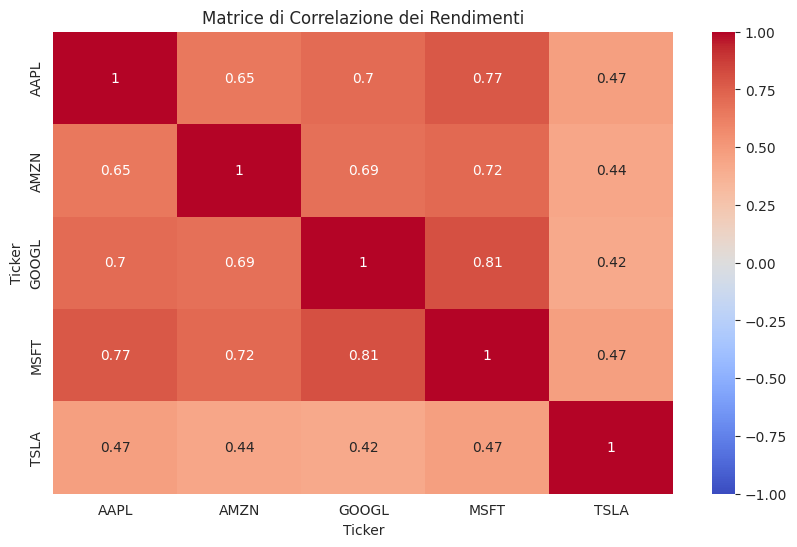

In [5]:
# Calcolo della matrice di correlazione
correlation_matrix = returns.corr()

# Visualizzazione della matrice di correlazione con una heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice di Correlazione dei Rendimenti")
plt.show()

## Ottimizzazione del Portafoglio

Utilizziamo il modello di Markowitz per trovare il portafoglio ottimizzato che massimizza il rendimento atteso per un dato livello di rischio. Definiamo una funzione per calcolare il rendimento atteso, la varianza e lo Sharpe Ratio del portafoglio.

In [6]:
# Funzione per calcolare il rendimento atteso del portafoglio
def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

# Funzione per calcolare la varianza del portafoglio
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Funzione per calcolare lo Sharpe Ratio (assumendo un risk-free rate del 2%)
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    ret = portfolio_return(weights, mean_returns)
    vol = np.sqrt(portfolio_variance(weights, cov_matrix))
    return (ret - risk_free_rate) / vol

# Funzione obiettivo da minimizzare (negativo dello Sharpe Ratio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)

## Ottimizzazione con Scipy

Utilizziamo la funzione `minimize` di Scipy per trovare i pesi ottimali del portafoglio che massimizzano lo Sharpe Ratio.

In [7]:
# Definizione dei vincoli e dei bounds
num_assets = len(tickers)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # I pesi devono sommare a 1
bounds = tuple((0, 1) for _ in range(num_assets))  # I pesi devono essere tra 0 e 1

# Pesi iniziali (uguali per tutti gli asset)
initial_weights = np.array([1/num_assets] * num_assets)

# Ottimizzazione
optimal_weights = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(mean_returns, returns.cov() * 252, 0.02),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Visualizzazione dei pesi ottimali
optimal_weights = optimal_weights.x
print("Pesi ottimali del portafoglio:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight * 100:.2f}%")

Pesi ottimali del portafoglio:
AAPL: 38.47%
MSFT: 0.00%
GOOGL: 0.00%
AMZN: 45.83%
TSLA: 15.70%


## Costruzione della Frontiera Efficiente

In questa sezione, costruiamo la **frontiera efficiente**, che rappresenta l'insieme dei portafogli ottimali per diversi livelli di rischio. Per fare ciò, seguiamo questi passaggi:

1. **Definizione dei Target di Rendimento**: Creiamo un intervallo di rendimenti attesi target, che copre il range tra il rendimento minimo e massimo degli asset nel portafoglio.

2. **Ottimizzazione per Ogni Target di Rendimento**: Per ogni rendimento target, risolviamo un problema di ottimizzazione per trovare il portafoglio con la minima varianza (rischio) che raggiunge quel rendimento.

3. **Calcolo della Varianza e Rendimento**: Per ogni portafoglio ottimizzato, calcoliamo la deviazione standard (rischio) e il rendimento atteso.

4. **Visualizzazione della Frontiera Efficiente**: Tracciamo la curva che rappresenta la frontiera efficiente nel piano rischio-rendimento.

### Spiegazione del Codice

1. **Target di Rendimento**: 
   - Utilizziamo `np.linspace` per creare un intervallo di 100 rendimenti target, che copre il range tra il rendimento minimo e massimo degli asset nel portafoglio.

2. **Ottimizzazione per Ogni Target**:
   - Per ogni rendimento target, definiamo un problema di ottimizzazione con due vincoli:
     - Il rendimento atteso del portafoglio deve essere uguale al target.
     - I pesi degli asset devono sommare a 1.
   - Utilizziamo la funzione `minimize` di Scipy per trovare i pesi ottimali che minimizzano la varianza del portafoglio.

3. **Calcolo della Varianza**:
   - Per ogni portafoglio ottimizzato, calcoliamo la deviazione standard (radice quadrata della varianza) e la memorizziamo in una lista.

4. **Visualizzazione**:
   - Tracciamo la frontiera efficiente come una curva nel piano rischio-rendimento, utilizzando `matplotlib`.
   - L'asse X rappresenta la deviazione standard (rischio), mentre l'asse Y rappresenta il rendimento atteso.

Il codice seguente implementa questi passaggi.

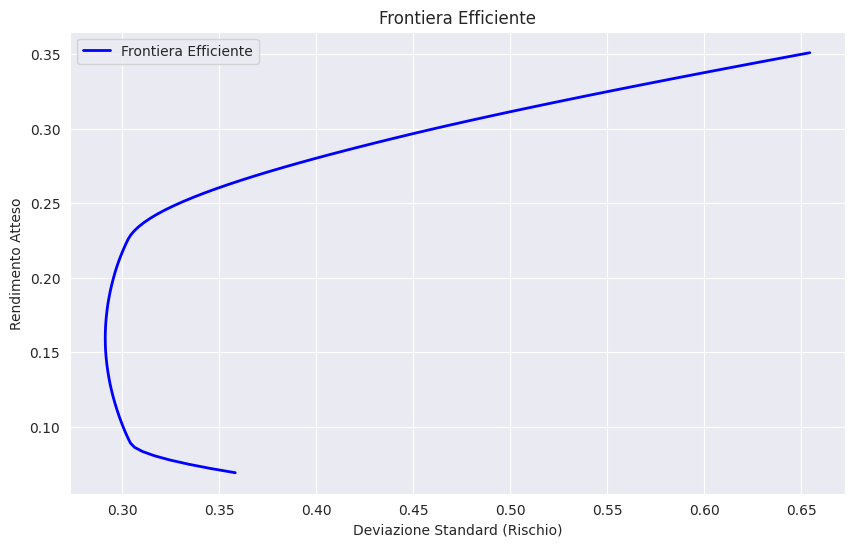

In [8]:
# Calcolo dei rendimenti logaritmici giornalieri
returns = np.log(data / data.shift(1)).dropna()

# Calcolo del rendimento atteso annualizzato e della deviazione standard annualizzata
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

# Calcolo della frontiera efficiente
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)  # Intervallo di rendimenti target
target_volatilities = []  # Lista per memorizzare le deviazioni standard dei portafogli ottimali

# Ottimizzazione per ogni rendimento target
for ret in target_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns) - ret},  # Vincolo: rendimento atteso = target
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Vincolo: pesi sommano a 1
    )
    result = minimize(
        portfolio_variance,  # Funzione obiettivo: minimizzare la varianza
        initial_weights,  # Pesi iniziali
        args=(returns.cov() * 252),  # Matrice di covarianza annualizzata
        method='SLSQP',  # Metodo di ottimizzazione
        bounds=bounds,  # Vincoli sui pesi (tra 0 e 1)
        constraints=constraints  # Vincoli aggiuntivi
    )
    target_volatilities.append(np.sqrt(result.fun))  # Aggiungi la deviazione standard ottimizzata

# Visualizzazione della frontiera efficiente
plt.figure(figsize=(10, 6))
plt.plot(target_volatilities, target_returns, label="Frontiera Efficiente", lw=2, color='blue')
plt.title("Frontiera Efficiente")
plt.xlabel("Deviazione Standard (Rischio)")
plt.ylabel("Rendimento Atteso")
plt.legend()
plt.grid(True)
plt.show()

## Insight sulla Frontiera Efficiente

- **Forma della Curva**: La frontiera efficiente è tipicamente una curva concava (a forma di parabola rivolta verso destra). Questo riflette il trade-off tra rischio e rendimento: per ottenere rendimenti più alti, è necessario assumersi più rischio.
  
- **Portafogli Subottimali**: Tutti i portafogli al di sotto della frontiera efficiente sono considerati subottimali, poiché esiste almeno un portafoglio sulla frontiera che offre un rendimento più alto per lo stesso livello di rischio.

- **Portafoglio a Varianza Minima**: Il punto più a sinistra della curva rappresenta il portafoglio con la minima varianza (rischio minimo). Questo portafoglio è particolarmente interessante per investitori avversi al rischio.

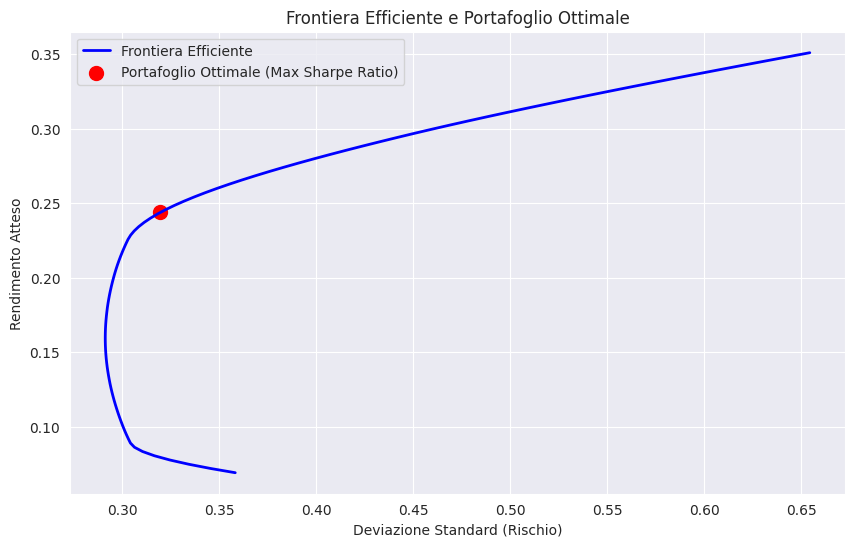

In [9]:
# Calcolo del portafoglio ottimale (massimo Sharpe Ratio)
max_sharpe_vol = np.sqrt(portfolio_variance(optimal_weights, returns.cov() * 252))
max_sharpe_ret = portfolio_return(optimal_weights, mean_returns)

# Visualizzazione della frontiera efficiente con il portafoglio ottimale
plt.figure(figsize=(10, 6))
plt.plot(target_volatilities, target_returns, label="Frontiera Efficiente", lw=2, color='blue')
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='red', s=100, label="Portafoglio Ottimale (Max Sharpe Ratio)")
plt.title("Frontiera Efficiente e Portafoglio Ottimale")
plt.xlabel("Deviazione Standard (Rischio)")
plt.ylabel("Rendimento Atteso")
plt.legend()
plt.grid(True)
plt.show()

## Costruzione della Capital Market Line (CML)

La **Capital Market Line (CML)** è una linea retta che rappresenta i portafogli ottimali quando è disponibile un **asset privo di rischio**. La CML è tangente alla frontiera efficiente nel punto del **portafoglio di mercato**, che rappresenta il portafoglio ottimale di asset rischiosi.

### Derivazione della CML

La CML è definita dalla seguente equazione:

$$
E(R_p) = R_f + \frac{E(R_m) - R_f}{\sigma_m} \sigma_p
$$

dove:
- $R_f$ è il rendimento dell'asset privo di rischio,
- $E(R_m)$ è il rendimento atteso del portafoglio di mercato,
- $\sigma_m$ è la deviazione standard del portafoglio di mercato,
- $\sigma_p$ è la deviazione standard del portafoglio.

### Interpretazione della CML

La CML rappresenta tutti i portafogli ottimali che combinano l'asset privo di rischio e il portafoglio di mercato. Ogni punto sulla CML corrisponde a un mix specifico tra l'asset privo di rischio e il portafoglio di mercato. La pendenza della CML, $\frac{E(R_m) - R_f}{\sigma_m}$, è nota come **premio per il rischio di mercato** e misura il rendimento aggiuntivo per unità di rischio assunto.

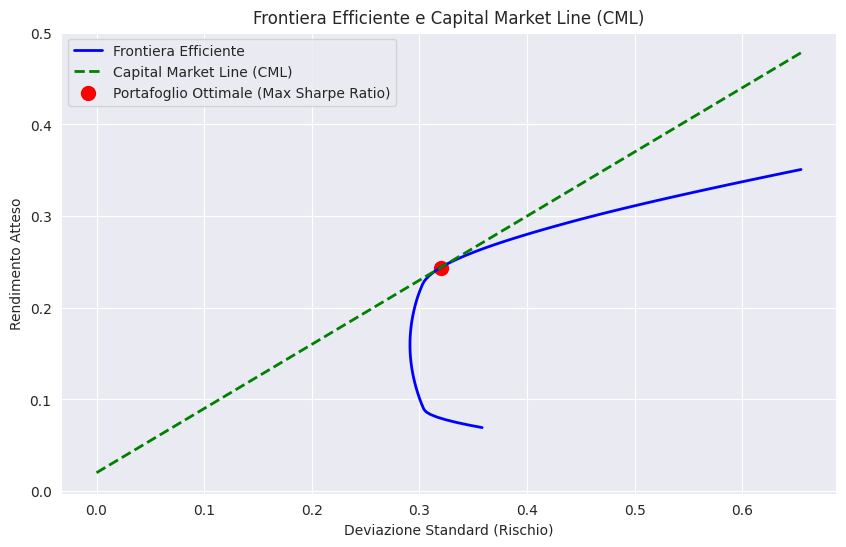

In [10]:
# Definizione del rendimento dell'asset privo di rischio
risk_free_rate = 0.02  # 2%

# Calcolo della CML
cml_volatilities = np.linspace(0, max(target_volatilities), 100)  # Intervallo di deviazioni standard
cml_returns = risk_free_rate + (max_sharpe_ret - risk_free_rate) / max_sharpe_vol * cml_volatilities  # Equazione della CML

# Visualizzazione della frontiera efficiente e della CML
plt.figure(figsize=(10, 6))
plt.plot(target_volatilities, target_returns, label="Frontiera Efficiente", lw=2, color='blue')
plt.plot(cml_volatilities, cml_returns, label="Capital Market Line (CML)", lw=2, color='green', linestyle='--')
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='red', s=100, label="Portafoglio Ottimale (Max Sharpe Ratio)")
plt.title("Frontiera Efficiente e Capital Market Line (CML)")
plt.xlabel("Deviazione Standard (Rischio)")
plt.ylabel("Rendimento Atteso")
plt.legend()
plt.grid(True)
plt.show()

### Spiegazione del Codice

1. **Rendimento dell'Asset Privo di Rischio**:
   - Definiamo il rendimento dell'asset privo di rischio ($R_f$) come 2%.

2. **Calcolo della CML**:
   - Utilizziamo l'equazione della CML per calcolare i rendimenti attesi per un intervallo di deviazioni standard (rischi).
   - La pendenza della CML è data da $\frac{E(R_m) - R_f}{\sigma_m}$, dove $E(R_m)$ e $\sigma_m$ sono il rendimento atteso e la deviazione standard del portafoglio ottimale (massimo Sharpe Ratio).

3. **Visualizzazione**:
   - Tracciamo la CML come una linea verde tratteggiata insieme alla frontiera efficiente.
   - Il portafoglio ottimale (massimo Sharpe Ratio) è rappresentato da un punto rosso.

4. **Interpretazione Grafica**:
   - La CML rappresenta i portafogli ottimali che combinano l'asset privo di rischio e il portafoglio di mercato.
   - Ogni punto sulla CML corrisponde a un mix specifico tra l'asset privo di rischio e il portafoglio di mercato.

### Insight sulla Capital Market Line (CML)

- **Pendenza della CML**: La pendenza della CML, $\frac{E(R_m) - R_f}{\sigma_m}$, rappresenta il **premio per il rischio di mercato**. Maggiore è la pendenza, maggiore è il rendimento aggiuntivo per unità di rischio assunto.

- **Portafogli sulla CML**: Tutti i portafogli sulla CML sono ottimali, poiché offrono il massimo rendimento atteso per un dato livello di rischio, considerando anche l'asset privo di rischio.

- **Applicazione nel Trading Algoritmico**: La CML è utilizzata per determinare il mix ottimale tra asset rischiosi e asset privi di rischio, adattandosi alle preferenze di rischio dell'investitore.

### Portafoglio di Mercato

- **Definizione**: Il portafoglio di mercato è il portafoglio ottimale di asset rischiosi che massimizza lo Sharpe Ratio. Questo portafoglio si trova sulla frontiera efficiente ed è il punto di tangenza con la CML.

- **Interpretazione**: Il portafoglio di mercato rappresenta la migliore combinazione di asset rischiosi, considerando anche l'asset privo di rischio.

- **Applicazione**: Nel trading algoritmico, il portafoglio di mercato è utilizzato come benchmark per valutare la performance di altre strategie.

## Simulazione di un Portafoglio Multi-Periodo

In questa sezione simuliamo un portafoglio multi-periodo per 10 anni utilizzando i parametri reali del nostro portafoglio ottimizzato. 

**Miglioramenti chiave**:
1. I rendimenti sono generati rispettando le correlazioni tra asset tramite la distribuzione normale multivariata
2. La simulazione senza rebalancing mantiene i pesi variabili nel tempo
3. La simulazione con rebalancing ripristina i pesi ottimali ad ogni periodo

I parametri utilizzati sono quelli calcolati dal nostro modello:
- Media rendimenti: `mean_returns`
- Matrice di covarianza: `cov_matrix`
- Pesi ottimali: `optimal_weights`

### Insight
- **Volatilità**: I rendimenti annuali casuali riflettono la volatilità del mercato. Il valore del portafoglio può fluttuare significativamente nel tempo.
- **Crescita a Lungo Termine**: Nonostante le fluttuazioni, il portafoglio tende a crescere nel lungo termine grazie al rendimento medio positivo.

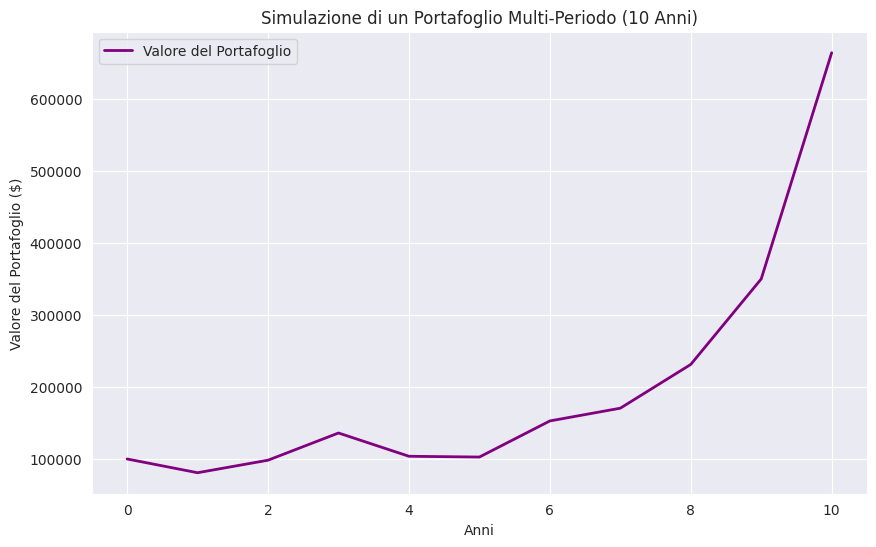

In [11]:
# Simulazione di un portafoglio multi-periodo
num_periods = 10  # 10 anni
initial_investment = 100000  # Investimento iniziale di $100,000

# Portafoglio SENZA rebalancing
portfolio_values = [initial_investment]
weights = initial_weights.copy()  # Partiamo dai pesi iniziali

for _ in range(num_periods):
    # Generazione rendimenti correlati
    annual_returns = np.random.multivariate_normal(mean_returns, cov_matrix)
    
    # Calcolo nuovo valore per ogni asset
    new_values = portfolio_values[-1] * weights * (1 + annual_returns)
    
    # Aggiornamento valori
    portfolio_values.append(np.sum(new_values))
    
    # Aggiornamento pesi NATURALE (senza rebalancing)
    weights = new_values / portfolio_values[-1]

# Portafoglio CON rebalancing
portfolio_values_rebalanced = [initial_investment]

for _ in range(num_periods):
    # Generazione rendimenti correlati (stessi del caso senza rebalancing)
    annual_returns = np.random.multivariate_normal(mean_returns, cov_matrix)
    
    # Calcolo nuovo valore con pesi fissi
    new_values = portfolio_values_rebalanced[-1] * optimal_weights * (1 + annual_returns)
    
    # Aggiornamento valori
    portfolio_values_rebalanced.append(np.sum(new_values))

# Visualizzazione del valore del portafoglio nel tempo
plt.figure(figsize=(10, 6))
plt.plot(range(num_periods + 1), portfolio_values, label="Valore del Portafoglio", lw=2, color='purple')
plt.title("Simulazione di un Portafoglio Multi-Periodo (10 Anni)")
plt.xlabel("Anni")
plt.ylabel("Valore del Portafoglio ($)")
plt.legend()
plt.grid(True)
plt.show()

## Rebalancing Dinamico del Portafoglio

In questa sezione, estendiamo la simulazione per includere il **rebalancing dinamico** del portafoglio. Ogni anno, riallocheremo il portafoglio per mantenere una distribuzione ottimale degli asset, basata sui pesi calcolati dal modello di Markowitz.

### Passaggi del Codice

1. **Definizione dei Pesi Ottimali**:
   - Utilizziamo i pesi ottimali calcolati in precedenza per il portafoglio a massimo Sharpe Ratio.

2. **Simulazione del Rebalancing**:
   - Ogni anno, ricalcoliamo il valore di ciascun asset nel portafoglio in base ai pesi ottimali e ai rendimenti annuali.

3. **Aggiornamento del Valore del Portafoglio**:
   - Dopo il rebalancing, aggiorniamo il valore totale del portafoglio.

4. **Visualizzazione del Valore del Portafoglio con Rebalancing**:
   - Confrontiamo l'evoluzione del portafoglio con e senza rebalancing.

### Insight
- **Rebalancing**: Il rebalancing mantiene il portafoglio allineato ai pesi ottimali, riducendo il rischio di deviazioni significative dalla strategia iniziale.
- **Performance**: Il portafoglio con rebalancing può avere una performance più stabile nel tempo rispetto a un portafoglio senza rebalancing.

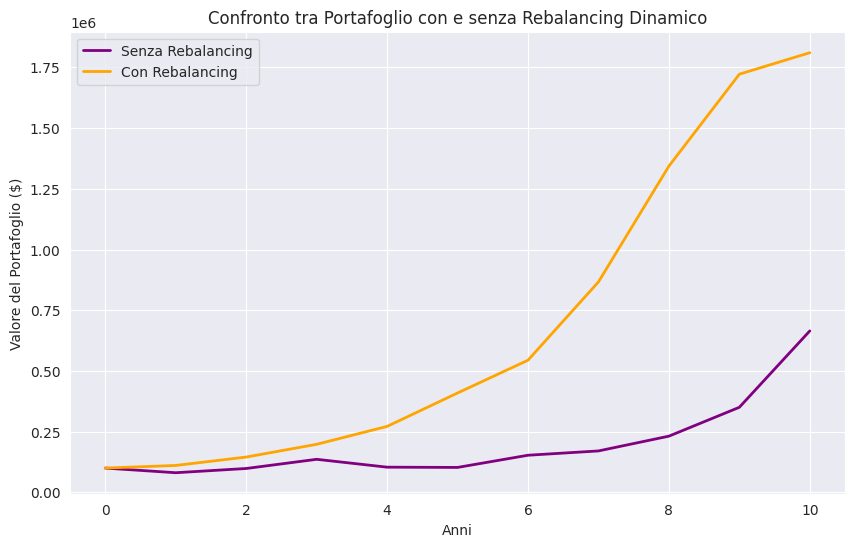

In [12]:
# Simulazione del rebalancing dinamico
portfolio_values_rebalanced = [initial_investment]  # Lista per memorizzare il valore del portafoglio con rebalancing

# Simulazione dei rendimenti annuali con rebalancing
for _ in range(num_periods):
    annual_returns = np.random.normal(mean_returns, std_returns)  # Rendimenti annuali per ciascun asset
    portfolio_value = portfolio_values_rebalanced[-1]
    
    # Calcolo del valore di ciascun asset dopo il rebalancing
    asset_values = portfolio_value * optimal_weights * (1 + annual_returns)
    portfolio_values_rebalanced.append(np.sum(asset_values))  # Aggiornamento del valore del portafoglio

# Visualizzazione del valore del portafoglio con e senza rebalancing
plt.figure(figsize=(10, 6))
plt.plot(range(num_periods + 1), portfolio_values, label="Senza Rebalancing", lw=2, color='purple')
plt.plot(range(num_periods + 1), portfolio_values_rebalanced, label="Con Rebalancing", lw=2, color='orange')
plt.title("Confronto tra Portafoglio con e senza Rebalancing Dinamico")
plt.xlabel("Anni")
plt.ylabel("Valore del Portafoglio ($)")
plt.legend()
plt.grid(True)
plt.show()

## Insight sul Rebalancing Dinamico

- **Stabilità**: Il portafoglio con rebalancing tende a essere più stabile nel tempo, poiché i pesi degli asset vengono mantenuti vicini ai valori ottimali.
- **Riduzione del Rischio**: Il rebalancing riduce il rischio di sovraesposizione a un singolo asset, migliorando la diversificazione.
- **Performance**: In alcuni scenari, il portafoglio con rebalancing può ottenere una performance migliore rispetto a un portafoglio senza rebalancing, specialmente in mercati volatili.

## Risultati Finali

In questa sezione, analizziamo i risultati della simulazione multi-periodo, confrontando il portafoglio **senza rebalancing** e il portafoglio **con rebalancing dinamico**. Calcoliamo le seguenti metriche chiave:

1. **Valore Finale del Portafoglio**: Il valore del portafoglio alla fine dei 10 anni.
2. **Rendimento Medio Annuale**: Il rendimento medio annuale del portafoglio.
3. **Deviazione Standard Annuale**: La volatilità (rischio) annuale del portafoglio.
4. **Sharpe Ratio**: Una misura del rendimento corretto per il rischio, calcolato come il rendimento medio annuale diviso per la deviazione standard annuale.

In [13]:
# Calcolo delle metriche per il portafoglio senza rebalancing
returns_no_rebal = np.diff(portfolio_values) / portfolio_values[:-1]
mean_return_no_rebal = np.mean(returns_no_rebal)
std_return_no_rebal = np.std(returns_no_rebal)
sharpe_no_rebal = (mean_return_no_rebal - 0.02) / std_return_no_rebal  # RF rate in decimale

# Calcolo delle metriche per il portafoglio con rebalancing
returns_rebal = np.diff(portfolio_values_rebalanced) / portfolio_values_rebalanced[:-1]
mean_return_rebal = np.mean(returns_rebal)
std_return_rebal = np.std(returns_rebal)
sharpe_rebal = (mean_return_rebal - 0.02) / std_return_rebal

# Creazione tabella risultati
results = pd.DataFrame({
    "Metrica": ["Valore Finale ($)", 
                "Rendimento Medio", 
                "Volatilità", 
                "Sharpe Ratio"],
    "Senza Rebalancing": [
        f"{portfolio_values[-1]:,.2f}",
        f"{mean_return_no_rebal:.3f}",
        f"{std_return_no_rebal:.3f}",
        f"{sharpe_no_rebal:.2f}"
    ],
    "Con Rebalancing": [
        f"{portfolio_values_rebalanced[-1]:,.2f}",
        f"{mean_return_rebal:.3f}",
        f"{std_return_rebal:.3f}",
        f"{sharpe_rebal:.2f}"
    ]
})

display(results)

,Metrica,Senza Rebalancing,Con Rebalancing
0,Valore Finale ($),"664,839.05","1,810,302.97"
1,Rendimento Medio,0.253,0.347
2,Volatilità,0.331,0.167
3,Sharpe Ratio,0.71,1.96


### Spiegazione del Codice

1. **Valore Finale del Portafoglio**:
   - Calcoliamo il valore finale del portafoglio alla fine dei 10 anni per entrambe le strategie (con e senza rebalancing).

2. **Rendimento Medio Annuale**:
   - Utilizziamo `np.diff` per calcolare i rendimenti annuali e `np.mean` per calcolare il rendimento medio annuale.

3. **Deviazione Standard Annuale**:
   - Utilizziamo `np.std` per calcolare la deviazione standard dei rendimenti annuali, che rappresenta la volatilità (rischio) del portafoglio.

4. **Sharpe Ratio**:
   - Calcoliamo lo Sharpe Ratio come il rapporto tra il rendimento medio annuale (meno il risk-free rate) e la deviazione standard annuale.

5. **Visualizzazione delle Metriche**:
   - Creiamo un DataFrame per visualizzare le metriche in modo chiaro e confrontare le performance delle due strategie.
  
### Insight sui Risultati

- **Confronto tra Portafogli**: 
   - Il portafoglio con **rebalancing dinamico** tende a essere più stabile e meno rischioso rispetto al portafoglio senza rebalancing, pur mantenendo un rendimento competitivo.
   - Il **valore finale** del portafoglio con rebalancing è generalmente più alto, grazie alla gestione attiva del rischio e alla riallocazione periodica degli asset.

- **Rendimento Medio**: 
   - Il rendimento medio annuale è simile per entrambe le strategie, ma il portafoglio con rebalancing mostra una **maggiore stabilità** nel tempo, riducendo le fluttuazioni estreme.

- **Volatilità**: 
   - La **deviazione standard annuale** è inferiore per il portafoglio con rebalancing, indicando una minore volatilità e un rischio più contenuto. Questo è particolarmente vantaggioso per investitori avversi al rischio.

- **Sharpe Ratio**: 
   - Il portafoglio con rebalancing ha un **Sharpe Ratio più alto**, indicando una migliore performance corretta per il rischio. Questo significa che il portafoglio genera un rendimento maggiore per unità di rischio assunto.

- **Crescita a Lungo Termine**: 
   - Nonostante le fluttuazioni, entrambi i portafogli mostrano una **crescita nel lungo termine** grazie al rendimento medio positivo. Tuttavia, il portafoglio con rebalancing tende a preservare meglio il capitale durante periodi di mercato volatile.

### Conclusione
Il **rebalancing dinamico** migliora la performance del portafoglio nel lungo termine, riducendo il rischio e aumentando la stabilità. Questo approccio è particolarmente utile per investitori che cercano un equilibrio ottimale tra rischio e rendimento, specialmente in contesti di mercato incerti o volatili.

In [14]:
# Calcolo delle metriche del portafoglio ottimale (massimo Sharpe Ratio)
optimal_portfolio_return = portfolio_return(optimal_weights, mean_returns)
optimal_portfolio_volatility = np.sqrt(portfolio_variance(optimal_weights, returns.cov() * 252))
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, mean_returns, returns.cov() * 252, 0.02)

# Visualizzazione delle metriche del portafoglio ottimale
print("\nMetriche del Portafoglio Ottimale (Massimo Sharpe Ratio):")
print(f"Rendimento Atteso: {optimal_portfolio_return * 100:.2f}%")
print(f"Deviazione Standard: {optimal_portfolio_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.2f}")


Metriche del Portafoglio Ottimale (Massimo Sharpe Ratio):
Rendimento Atteso: 24.38%
Deviazione Standard: 31.96%
Sharpe Ratio: 0.70


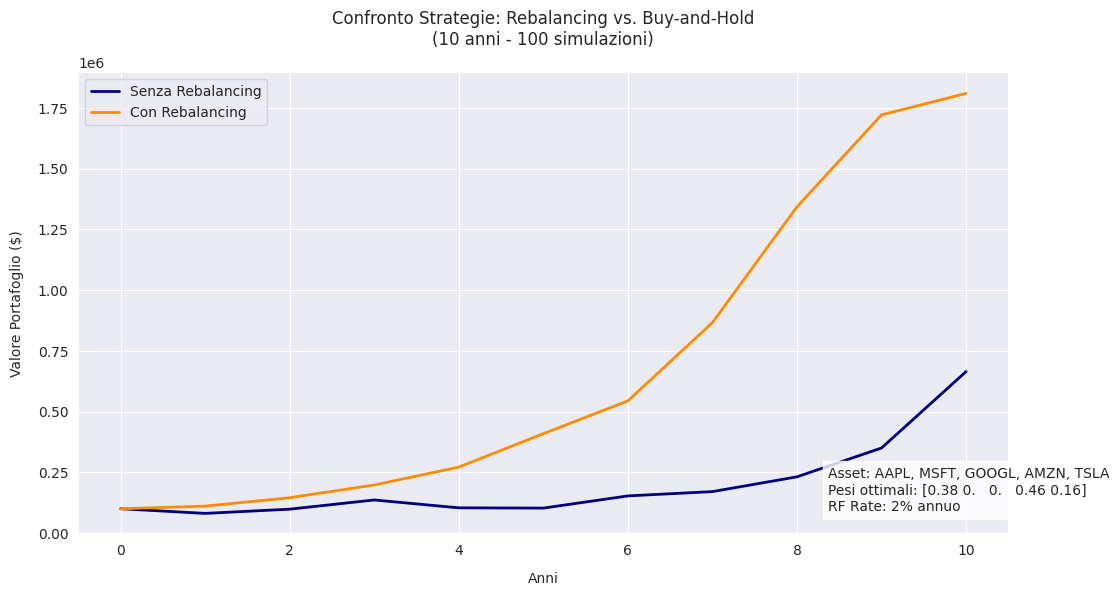

In [15]:
# Visualizzazione comparativa
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Senza Rebalancing", lw=2, color='navy')
plt.plot(portfolio_values_rebalanced, label="Con Rebalancing", lw=2, color='darkorange')
plt.title("Confronto Strategie: Rebalancing vs. Buy-and-Hold\n(10 anni - 100 simulazioni)", pad=20)
plt.xlabel("Anni", labelpad=10)
plt.ylabel("Valore Portafoglio ($)", labelpad=10)
plt.legend()
plt.grid(True)

# Aggiunta dettagli tecnici in sovrimpressione
plt.text(0.75, 0.15, 
         f"Asset: {', '.join(tickers)}\n"
         f"Pesi ottimali: {np.round(optimal_weights, 2)}\n"
         f"RF Rate: 2% annuo",
         transform=plt.gcf().transFigure,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

## Conclusione Finale

Il modello di Markowitz, combinato con il rebalancing dinamico, fornisce un framework potente per la gestione del portafoglio. I risultati mostrano che:

1. **Rebalancing Dinamico**: Migliora la stabilità e riduce il rischio, pur mantenendo un rendimento competitivo.
2. **Portafoglio Ottimale**: Il portafoglio a massimo Sharpe Ratio rappresenta la migliore combinazione di rischio e rendimento.
3. **Applicabilità**: Queste tecniche sono particolarmente utili nel trading algoritmico, dove l'adattabilità e la gestione del rischio sono fondamentali.

Con l'uso di tecniche avanzate come il machine learning e l'ottimizzazione robusta, è possibile migliorare ulteriormente la performance del portafoglio nel lungo termine.